In [ ]:
import json, random, shutil, hashlib
from pathlib import Path
from PIL import Image
from tqdm import tqdm

SRC_JSON = "doors_coco_1000.json"
OUT_ROOT = Path("dataset_clean")   # new clean dataset dir to avoid overwriting
SPLITS = {"train": 0.8, "valid": 0.1, "test": 0.1}
random.seed(0)

# ---- load source ----
data = json.load(open(SRC_JSON))
images_all = data["images"]
anns_all   = data["annotations"]
info       = data.get("info", {})
licenses   = data.get("licenses", [])
# single-class categories forced
cats = [{"id": 0, "name": "door", "supercategory": "door"}]

# ---- split ----
imgs = images_all[:]
random.shuffle(imgs)
n = len(imgs)
n_train = int(SPLITS["train"] * n)
n_valid = int(SPLITS["valid"] * n)
splits = {
    "train": imgs[:n_train],
    "valid": imgs[n_train:n_train+n_valid],
    "test":  imgs[n_train+n_valid:],
}

# ---- helpers ----
def unique_name_from_path(p: Path, img_id: int):
    # include a short hash of the absolute path to avoid collisions
    h = hashlib.md5(str(p).encode("utf-8")).hexdigest()[:8]
    return f"{img_id}_{h}_{p.name}"

def build_split(split_name, split_imgs):
    split_dir = OUT_ROOT / split_name
    split_dir.mkdir(parents=True, exist_ok=True)

    id_keep = set()
    new_images = []
    missing = 0

    for im in tqdm(split_imgs, desc=f"Copy {split_name}", ncols=80):
        src = Path(im["file_name"])  # original absolute/long path in source JSON
        if not src.exists():
            # if files moved, you may need to adjust this root
            missing += 1
            continue
        uniq = unique_name_from_path(src, im["id"])
        dst = split_dir / uniq
        if not dst.exists():
            shutil.copy(src, dst)

        # verify true size from the copied image
        with Image.open(dst) as pil:
            w_true, h_true = pil.size

        new_im = {
            "id": im["id"],
            "file_name": uniq,      # IMPORTANT: unique basename only (no collisions)
            "width": w_true,        # overwrite with actual size
            "height": h_true
        }
        new_images.append(new_im)
        id_keep.add(im["id"])

    # filter and sanitize annotations
    new_anns = []
    dropped = {"missing_image":0, "bad_box":0}
    id2size = {im["id"]: (im["width"], im["height"]) for im in new_images}

    def clamp(v, lo, hi): 
        return max(lo, min(hi, v))

    for a in anns_all:
        if a["image_id"] not in id_keep:
            continue
        w, h = id2size[a["image_id"]]
        x, y, bw, bh = a["bbox"]
        # clamp & ensure positive size
        x = clamp(x, 0, max(0, w-1))
        y = clamp(y, 0, max(0, h-1))
        bw = max(1.0, min(bw, w - x))
        bh = max(1.0, min(bh, h - y))
        if bw <= 0 or bh <= 0:
            dropped["bad_box"] += 1
            continue
        new_a = dict(a)
        new_a["bbox"] = [float(x), float(y), float(bw), float(bh)]
        new_a["category_id"] = 0   # single-class
        new_anns.append(new_a)

    out_json = {
        "info": info,
        "licenses": licenses,
        "images": new_images,
        "annotations": new_anns,
        "categories": cats,
    }
    with open(split_dir / "_annotations.coco.json", "w") as f:
        json.dump(out_json, f)

    print(f"[{split_name}] imgs={len(new_images)} anns={len(new_anns)} missing_src={missing} dropped={dropped}")

for name, img_list in splits.items():
    build_split(name, img_list)

print("\n✅ Rebuild complete. Use dataset_clean/ for training.")

In [ ]:
# --- Block: Inspect 10 examples from test COCO (GT only) ---

import json, random
from pathlib import Path
from PIL import Image

# paths
test_dir  = Path("dataset_clean/test")
ann_path  = test_dir / "_annotations.coco.json"
assert ann_path.exists(), f"Missing {ann_path}"

# load annotations
with open(ann_path, "r") as f:
    coco = json.load(f)

img_by_id = {im["id"]: im for im in coco["images"]}
anns_by_img = {}
for a in coco["annotations"]:
    anns_by_img.setdefault(a["image_id"], []).append(a)

# sample 10 image IDs
all_ids = [im["id"] for im in coco["images"] if (test_dir / im["file_name"]).exists()]
sample_ids = random.sample(all_ids, k=min(10, len(all_ids)))

for i, img_id in enumerate(sample_ids, 1):
    im_meta = img_by_id[img_id]
    img_path = test_dir / im_meta["file_name"]
    W, H = im_meta["width"], im_meta["height"]

    gt_anns = anns_by_img.get(img_id, [])
    print(f"\n[{i}] {img_path.name}  size=({W}x{H})  GT_count={len(gt_anns)}")

    # show up to 3 bbox entries
    for j, ann in enumerate(gt_anns[:3]):
        x,y,w,h = ann["bbox"]
        print(f"   GT[{j}]: bbox(xywh)=[{x:.1f},{y:.1f},{w:.1f},{h:.1f}], cat={ann.get('category_id',0)}")

    # open once to confirm it loads
    try:
        img = Image.open(img_path).convert("RGB")
        print(f"   Image loaded, mode={img.mode}, size={img.size}")
    except Exception as e:
        print(f"   Could not open image: {e}")


[1] 562_6f8ab5ca_F1_scaled.png size=(1291x1474) GT=21
  GT[0] xyxy=[546.5,1146.9,555.5,1208.8]
  GT[1] xyxy=[626.7,641.0,701.8,658.4]
  GT[2] xyxy=[163.1,181.8,325.0,203.1]


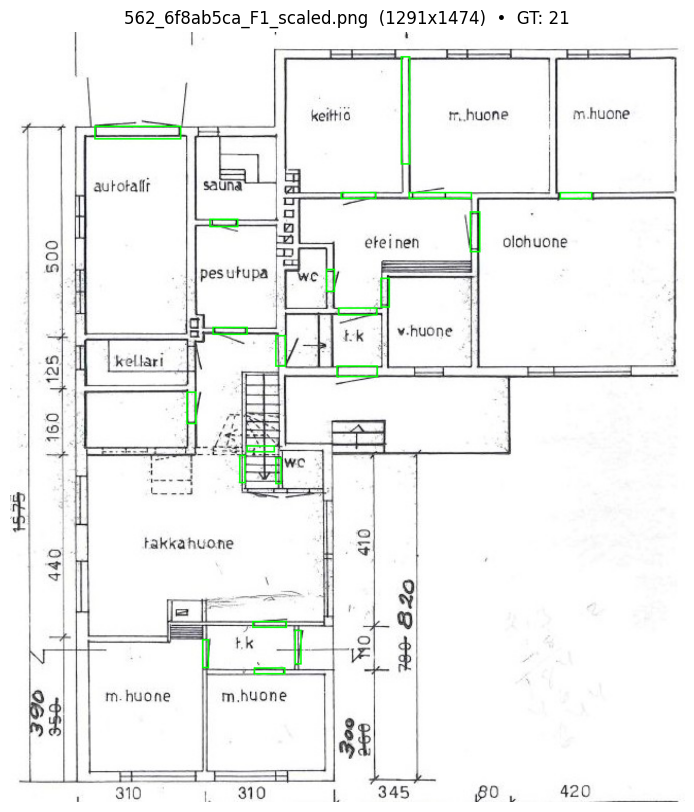


[2] 395_10ee7d98_F1_scaled.png size=(1544x1539) GT=16
  GT[0] xyxy=[379.7,1168.2,451.8,1194.2]
  GT[1] xyxy=[485.1,390.1,497.1,472.9]
  GT[2] xyxy=[459.7,803.0,469.6,861.8]


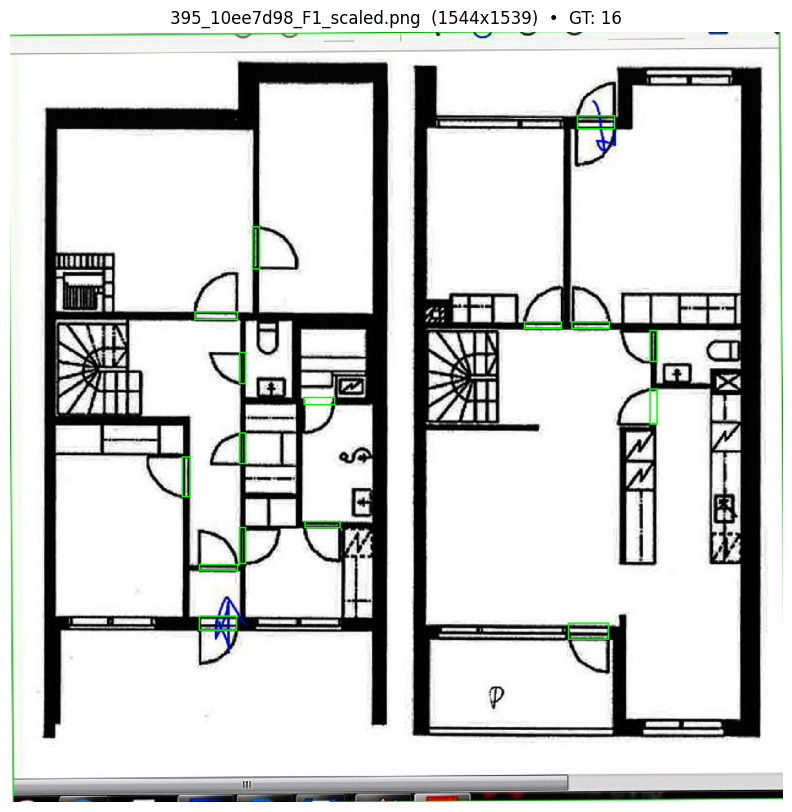


[3] 210_3fc0214f_F1_scaled.png size=(1543x1396) GT=8
  GT[0] xyxy=[1200.8,1233.9,1292.3,1254.9]
  GT[1] xyxy=[389.9,675.2,440.9,767.2]
  GT[2] xyxy=[1131.6,798.0,1211.3,814.0]


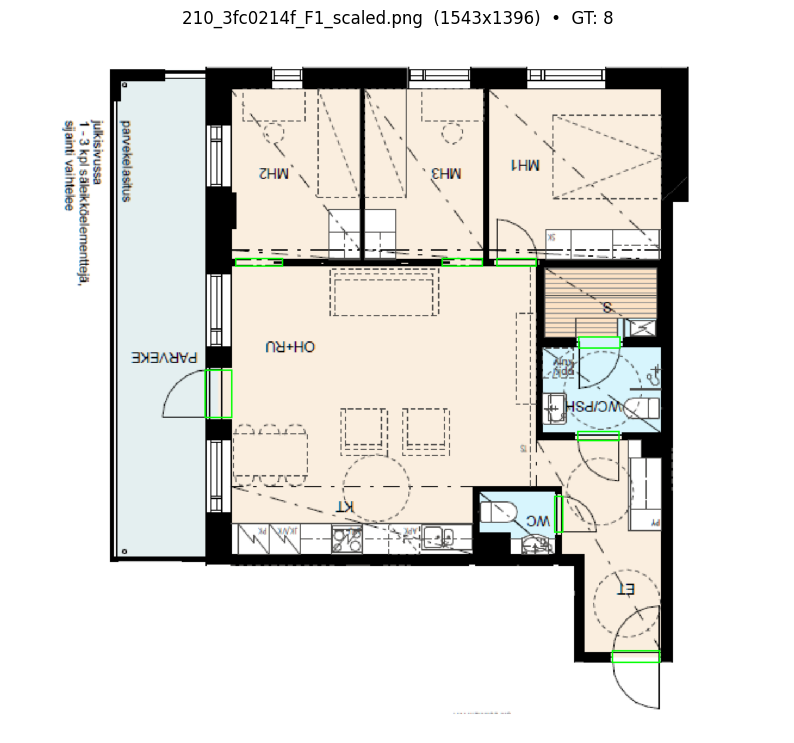


[4] 104_594e7d79_F1_scaled.png size=(1138x689) GT=7
  GT[0] xyxy=[378.7,587.7,446.4,600.0]
  GT[1] xyxy=[929.6,243.9,949.1,315.1]
  GT[2] xyxy=[361.3,333.3,369.6,402.2]


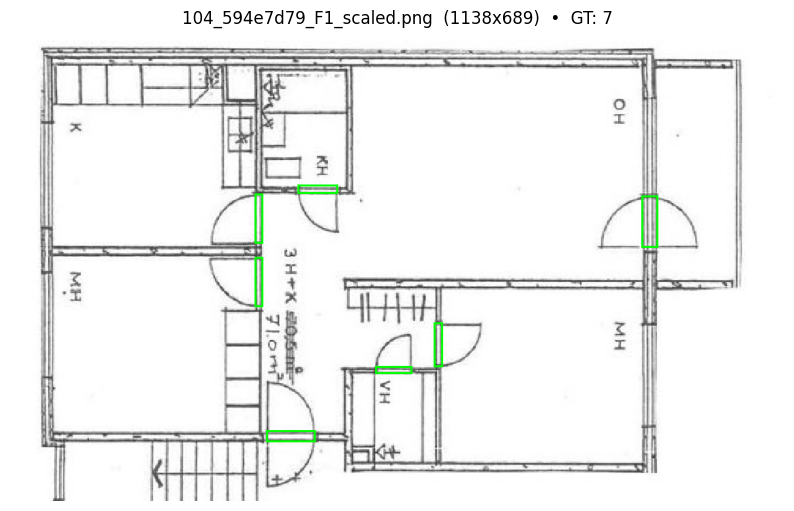


[5] 921_94ef649f_F1_scaled.png size=(2323x1743) GT=11
  GT[0] xyxy=[1055.1,1187.3,1126.1,1206.3]
  GT[1] xyxy=[1304.9,907.7,1313.9,969.8]
  GT[2] xyxy=[1067.9,868.3,1130.8,877.3]


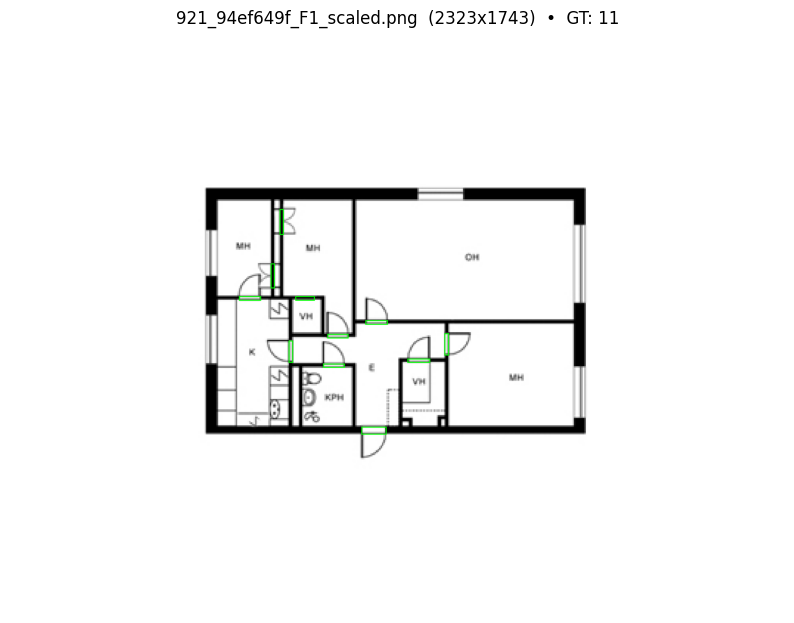


[6] 557_188c9c8c_F1_scaled.png size=(895x1608) GT=8
  GT[0] xyxy=[399.5,312.2,490.8,349.2]
  GT[1] xyxy=[325.0,1217.6,422.6,1249.8]
  GT[2] xyxy=[204.2,1313.2,224.2,1410.2]


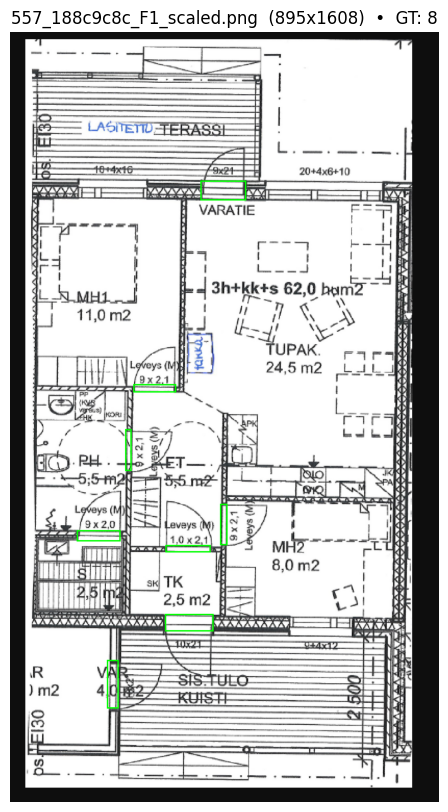


[7] 930_1817da69_F1_scaled.png size=(1508x1221) GT=7
  GT[0] xyxy=[1398.5,475.8,1434.2,531.1]
  GT[1] xyxy=[835.7,994.7,912.7,1016.7]
  GT[2] xyxy=[958.8,455.7,1027.7,467.7]


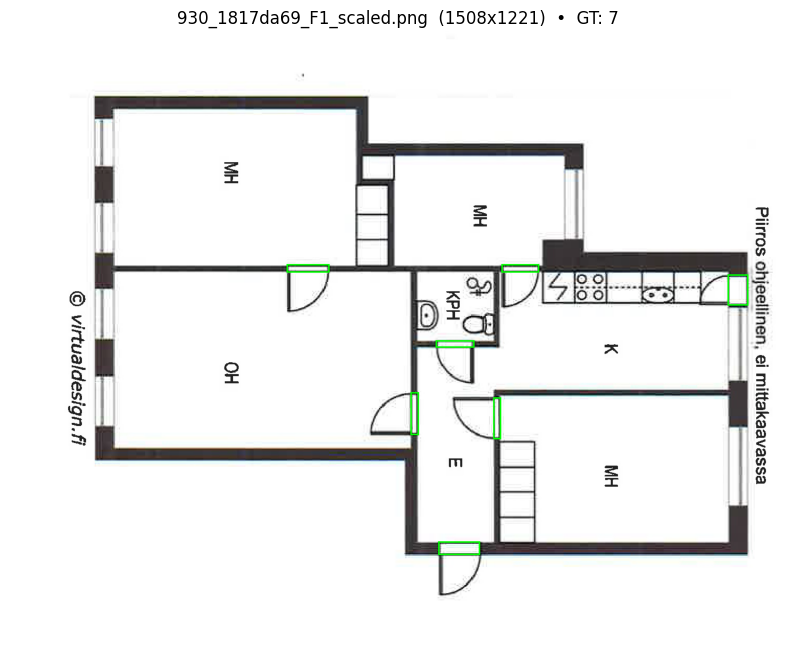


[8] 415_bd643e36_F1_scaled.png size=(1349x1507) GT=6
  GT[0] xyxy=[751.2,956.3,820.6,979.3]
  GT[1] xyxy=[328.0,998.2,351.0,1071.8]
  GT[2] xyxy=[632.0,956.6,701.4,979.7]


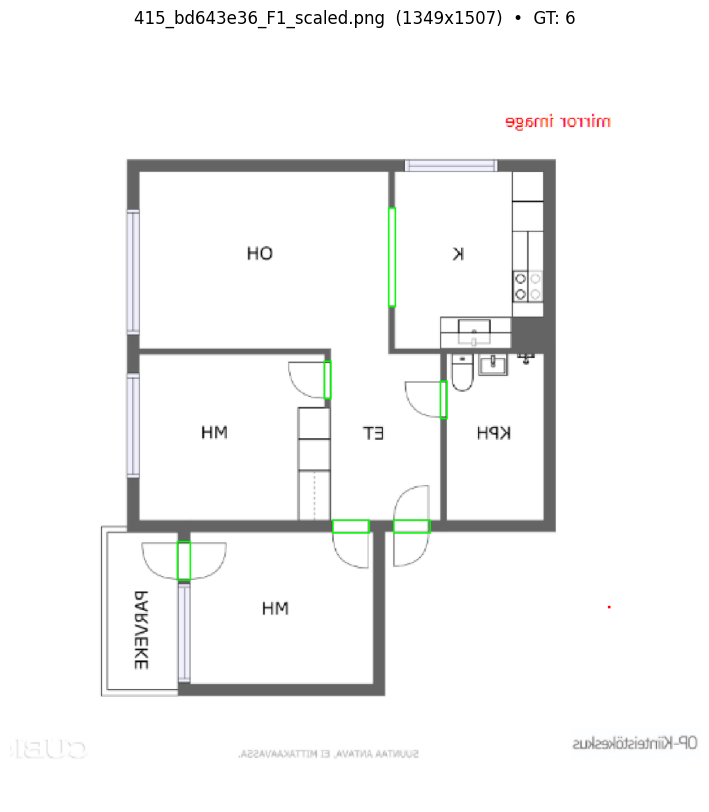


[9] 830_b4427e64_F1_scaled.png size=(3048x3092) GT=22
  GT[0] xyxy=[1167.0,2661.8,1256.1,2692.8]
  GT[1] xyxy=[1043.3,1670.1,1132.5,1699.1]
  GT[2] xyxy=[902.6,1566.3,929.6,1654.1]


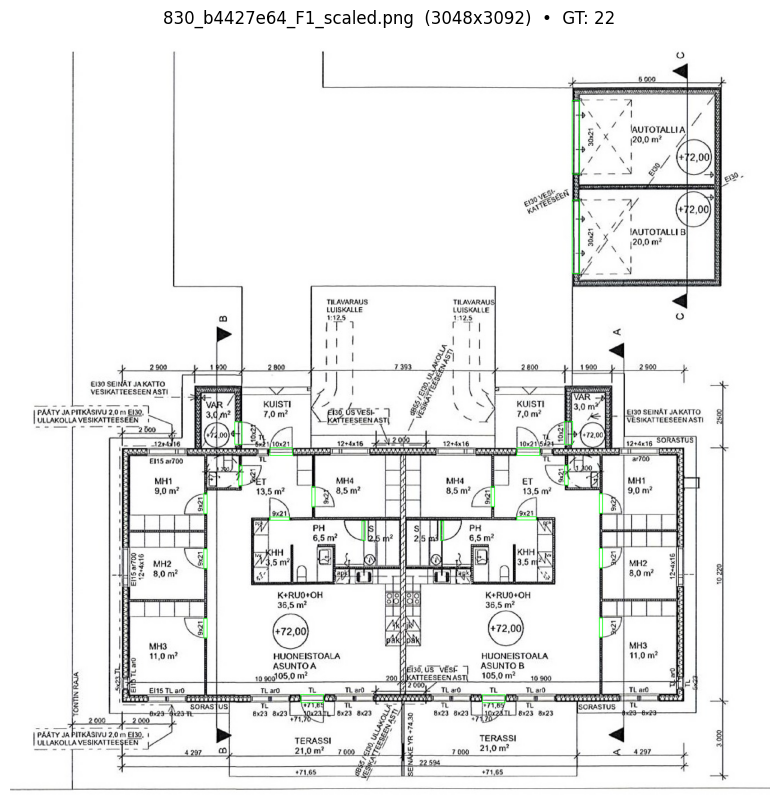


[10] 311_45eaf97c_F1_scaled.png size=(1867x2047) GT=10
  GT[0] xyxy=[471.1,489.5,548.4,573.0]
  GT[1] xyxy=[638.8,610.8,649.1,685.2]
  GT[2] xyxy=[662.9,688.2,722.6,699.9]


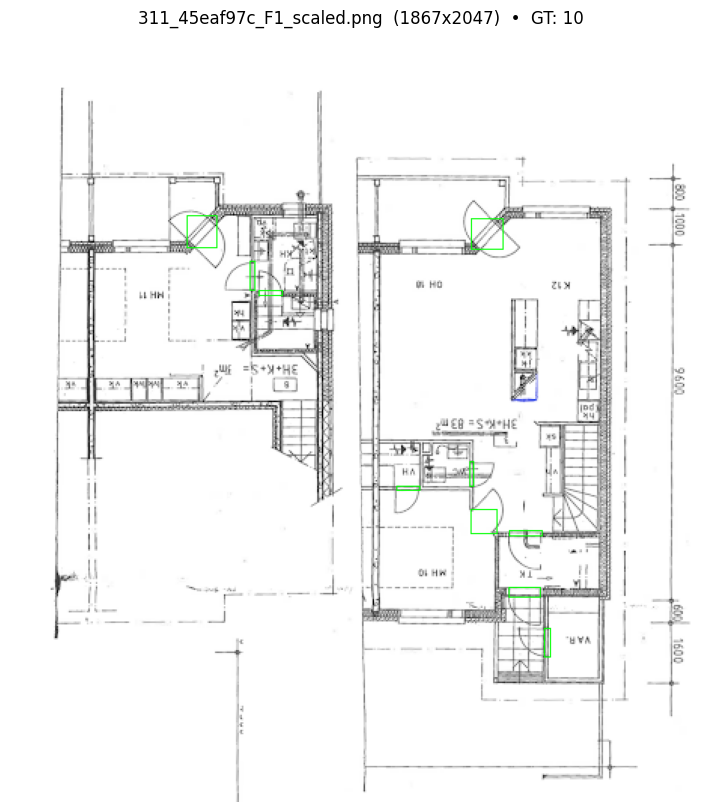

In [7]:
# --- Visualize GT (green) for 10 test samples with PIL only (no supervision) ---

import json, random
from pathlib import Path
import numpy as np
from PIL import Image, ImageDraw
import matplotlib.pyplot as plt

# point to your clean dataset split
test_dir  = Path("dataset_clean/test")   # <-- change if needed
ann_path  = test_dir / "_annotations.coco.json"
assert ann_path.exists(), f"Missing {ann_path}"

with open(ann_path, "r") as f:
    coco = json.load(f)

img_by_id = {im["id"]: im for im in coco["images"]}
anns_by_img = {}
for a in coco["annotations"]:
    anns_by_img.setdefault(a["image_id"], []).append(a)

all_ids = [im["id"] for im in coco["images"] if (test_dir / im["file_name"]).exists()]
sample_ids = random.sample(all_ids, k=min(10, len(all_ids)))

def xywh_to_xyxy(b):
    x,y,w,h = b
    return [x, y, x+w, y+h]

def draw_rect(draw: ImageDraw.Draw, box, color=(0,255,0), width=3):
    # draw rectangle with thickness
    x1,y1,x2,y2 = map(int, box)
    for t in range(width):
        draw.rectangle([x1-t, y1-t, x2+t, y2+t], outline=color)

for i, img_id in enumerate(sample_ids, 1):
    im = img_by_id[img_id]
    img_path = test_dir / im["file_name"]
    img = Image.open(img_path).convert("RGB")
    W, H = img.size

    gt_anns = anns_by_img.get(img_id, [])
    gt_xyxy = np.array([xywh_to_xyxy(a["bbox"]) for a in gt_anns], dtype=np.float32) if gt_anns else np.zeros((0,4), dtype=np.float32)

    # print some GT rows
    print(f"\n[{i}] {img_path.name} size=({W}x{H}) GT={len(gt_xyxy)}")
    for j in range(min(3, len(gt_xyxy))):
        x1,y1,x2,y2 = gt_xyxy[j]
        print(f"  GT[{j}] xyxy=[{x1:.1f},{y1:.1f},{x2:.1f},{y2:.1f}]")

    # draw GT boxes in green
    vis = img.copy()
    draw = ImageDraw.Draw(vis)
    for box in gt_xyxy:
        draw_rect(draw, box, color=(0,255,0), width=3)

    # show inline
    plt.figure(figsize=(10, 10))
    plt.title(f"{img_path.name}  ({W}x{H})  •  GT: {len(gt_xyxy)}")
    plt.imshow(vis)
    plt.axis("off")
    plt.show()